In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import gensim
import string
import spacy
en = spacy.load('en_core_web_sm')
stopwords = list(en.Defaults.stop_words)
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

## Loading Data

In [2]:
beer_data = pd.read_csv('BeerDataScienceProject.csv', encoding_errors='ignore')
beer_data.head()

,beer_ABV,beer_beerId,beer_brewerId,beer_name,beer_style,review_appearance,review_palette,review_overall,review_taste,review_profileName,review_aroma,review_text,review_time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot. In the smell some ba...,1.234818e+09
1,6.2,48213,10325,Red Moon,English Strong Ale,3.0,2.5,3.0,3,stcules,3,"Dark red color, light beige foam, average. In ...",1.235915e+09
2,6.5,48215,10325,Black Horse Black Beer,Foreign / Export Stout,3.0,2.5,3.0,3,stcules,3,"Almost totally black. Beige foam, quite compac...",1.235917e+09
3,5.0,47969,10325,Sausa Pils,German Pilsener,3.5,3.0,3.0,2.5,stcules,3,"Golden yellow color. White, compact foam, quit...",1.234725e+09
4,7.7,64883,1075,Cauldron DIPA,American Double / Imperial IPA,4.0,4.5,4.0,4,johnmichaelsen,4.5,"According to the website, the style for the Ca...",1.293735e+09


In [168]:
beer_data.nunique()

beer_ABV                 283
beer_beerId            14938
beer_brewerId           1604
beer_name              13976
beer_style               104
review_appearance         10
review_palette             9
review_overall            10
review_taste               9
review_profileName     22548
review_aroma               9
review_text           507238
review_time           506713
dtype: int64

# Checking null values 

In [3]:
beer_data.isnull().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              3
review_text             116
review_time             794
dtype: int64

### Since the number of null values is significantly low, so removing the null values

In [4]:
beer_data = beer_data.dropna()

In [5]:
beer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507588 entries, 0 to 528796
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   beer_ABV            507588 non-null  float64
 1   beer_beerId         507588 non-null  int64  
 2   beer_brewerId       507588 non-null  int64  
 3   beer_name           507588 non-null  object 
 4   beer_style          507588 non-null  object 
 5   review_appearance   507588 non-null  float64
 6   review_palette      507588 non-null  float64
 7   review_overall      507588 non-null  float64
 8   review_taste        507588 non-null  object 
 9   review_profileName  507588 non-null  object 
 10  review_aroma        507588 non-null  object 
 11  review_text         507588 non-null  object 
 12  review_time         507588 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 54.2+ MB


In [101]:
beer_data['review_time'] = pd.to_datetime(beer_data['review_time'], unit='s')
beer_data['review_taste'] = beer_data['review_taste'].astype('float64')
beer_data['review_aroma'] = beer_data['review_aroma'].astype('float64')
beer_data['beer_beerId'] = beer_data['beer_beerId'].astype('str')
beer_data['beer_brewerId'] = beer_data['beer_brewerId'].astype('str')

In [7]:
beer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507588 entries, 0 to 528796
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   beer_ABV            507588 non-null  float64       
 1   beer_beerId         507588 non-null  object        
 2   beer_brewerId       507588 non-null  object        
 3   beer_name           507588 non-null  object        
 4   beer_style          507588 non-null  object        
 5   review_appearance   507588 non-null  float64       
 6   review_palette      507588 non-null  float64       
 7   review_overall      507588 non-null  float64       
 8   review_taste        507588 non-null  float64       
 9   review_profileName  507588 non-null  object        
 10  review_aroma        507588 non-null  object        
 11  review_text         507588 non-null  object        
 12  review_time         507588 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64

## Data Statistics

In [8]:
beer_data.describe()

,beer_ABV,review_appearance,review_palette,review_overall,review_taste
count,507588.000000,507588.000000,507588.000000,507588.000000,507588.000000
mean,7.016978,3.872634,3.768843,3.840823,3.775269
std,2.205277,0.601790,0.682457,0.706479,0.665653
min,0.010000,0.000000,1.000000,0.000000,1.000000
25%,5.300000,3.500000,3.500000,3.500000,3.500000
50%,6.500000,4.000000,4.000000,4.000000,4.000000
75%,8.500000,4.000000,4.000000,4.500000,4.000000
max,57.700000,5.000000,5.000000,5.000000,5.000000


# Rank top 3 Breweries which produce the strongest beers

#### Strong beers are categorised by Alcohol by Volume Content, Strong Beers are those beers which have ABV higher than 8

### Hence the strongest beers are shown below

In [83]:
beerABV_groupby = beer_data.groupby(['beer_beerId','beer_name'])['beer_ABV'].mean().sort_values(ascending=False).reset_index().drop_duplicates('beer_name')
strongest_beers = beerABV_groupby[beerABV_groupby['beer_ABV'] >= 8]['beer_beerId']
strongest_beers

0       73368
1       57856
2       55712
3       51466
4       25759
        ...  
2958     2363
2959    71340
2960    74686
2961     2362
2962    21785
Name: beer_beerId, Length: 2885, dtype: object

### Ranking The Brewery according to the count of their strong beers

In [84]:
brewery_selling_strong_beers = beer_data.loc[beer_data['beer_beerId'].isin(strongest_beers)]
brewery_selling_strong_beers_count = brewery_selling_strong_beers.groupby(['beer_brewerId'])['beer_beerId'].count().reset_index().sort_values('beer_beerId', ascending=False)[:5].rename(columns = {'beer_beerId':'beer_beerId_count'})

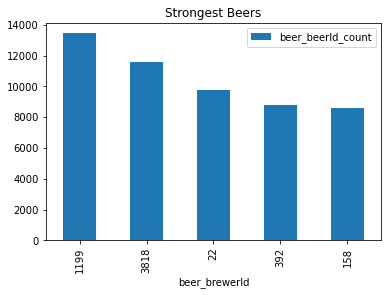

In [144]:
brewery_selling_strong_beers_count.plot(kind = 'bar', x='beer_brewerId', y='beer_beerId_count', title='Strongest Beers')
plt.savefig("D:\\BeerDataScienceProject\\Strong_beers_plot.png")

# Which year did beers enjoy the highest ratings?

In [88]:
columns= ['review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'review_overall']
beer_data_years = pd.DataFrame(beer_data[columns])
beer_data_years.insert(0,'year',beer_data['review_time'].dt.year, True)

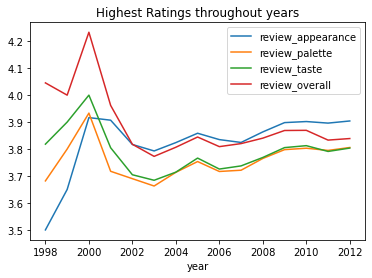

In [145]:
beer_data_years.groupby(['year']).mean().plot(kind='line', title = 'Highest Ratings throughout years')
plt.savefig("D:\\BeerDataScienceProject\\Highest_Ratings_throughout_years.png")

#### So the beers enjoyed highest ratings in 2000 since the graph has the highest peaks in the year 2000. After which the quality of beers reduced(according to the ratings). 
#### Since 2005 the ratings have improved. The beers achieved highest ratings in 2010 after 2000 in all aspects. Therefor the years beers enjoyed highest ratings are 2000, 2005, 2009, 2010

# Based on the user’s ratings which factors are important among taste, aroma, appearance, and palette?

In [169]:
beer_data_factors = beer_data[columns]
beer_data_factors.corr()

,review_appearance,review_palette,review_taste,review_aroma,review_overall
review_appearance,1.000000,0.544890,0.552111,0.531406,0.483125
review_palette,0.544890,1.000000,0.600932,0.703514,0.598055
review_taste,0.552111,0.600932,1.000000,0.722836,0.689306
review_aroma,0.531406,0.703514,0.722836,1.000000,0.780305
review_overall,0.483125,0.598055,0.689306,0.780305,1.000000


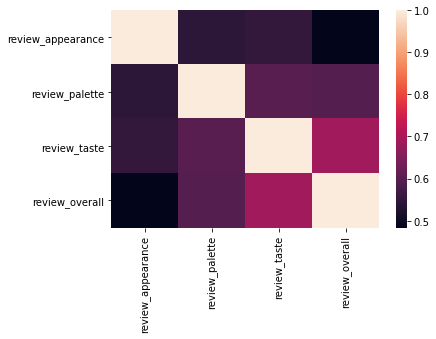

In [93]:
heatmap = sb.heatmap(beer_data_factors.corr())

In [ ]:
plt.savefig("D:\\BeerDataScienceProject\\important_factors.png")

### According to the table and the heatmap, it is seen that Aroma and Taste of the Beer are significantly correlated with the Overall ratings, hence we can come to the conclusion that Aroma and Taste influence the Overall ratings

# If you were to recommend 3 beers to your friends based on this data which ones will you recommend?

In [102]:
strong_beer_data = beer_data[beer_data['beer_ABV'] >= 8]
medium_beer_data = beer_data[(beer_data['beer_ABV'] >= 5) &(beer_data['beer_ABV'] < 8)]
light_beer_data = beer_data[(beer_data['beer_ABV'] >= 3) & (beer_data['beer_ABV'] < 5)]

In [103]:
strong_beer_data.corr()['review_overall']

beer_ABV            -0.039986
review_appearance    0.414788
review_palette       0.559277
review_overall       1.000000
review_taste         0.655945
review_aroma         0.765404
Name: review_overall, dtype: float64

In [104]:
medium_beer_data.corr()['review_overall']

beer_ABV             0.125128
review_appearance    0.469940
review_palette       0.593748
review_overall       1.000000
review_taste         0.688623
review_aroma         0.782771
Name: review_overall, dtype: float64

In [105]:
light_beer_data.corr()['review_overall']

beer_ABV             0.109885
review_appearance    0.542302
review_palette       0.635820
review_overall       1.000000
review_taste         0.720195
review_aroma         0.798750
Name: review_overall, dtype: float64

#### A Good correlation would be a correlation value of above 0.5 hence extracting those beers whose correlation between various factors and overall ratings is greater than 0.5

In [106]:
strong_beer_data_best_beers = strong_beer_data.groupby(['beer_beerId'])['review_aroma','review_taste','review_palette','review_overall'].mean().sort_values(['review_aroma','review_taste','review_palette','review_overall'], ascending=False)
strong_beer_data_best_beers.head()[:3]

<ipython-input-106-efca29fe7214>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  strong_beer_data_best_beers = strong_beer_data.groupby(['beer_beerId'])['review_aroma','review_taste','review_palette','review_overall'].mean().sort_values(['review_aroma','review_taste','review_palette','review_overall'], ascending=False)


,review_aroma,review_taste,review_palette,review_overall
beer_beerId,,,,
1734,5.0,5.0,5.0,5.0
29423,5.0,5.0,5.0,5.0
44449,5.0,5.0,5.0,5.0


In [107]:
medium_beer_data_best_beers = medium_beer_data.groupby(['beer_beerId'])['review_aroma','review_taste','review_palette','review_overall'].mean().sort_values(['review_aroma','review_taste','review_palette','review_overall'], ascending=False)
medium_beer_data_best_beers.head()[:3]

<ipython-input-107-fb2efb8e8aed>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  medium_beer_data_best_beers = medium_beer_data.groupby(['beer_beerId'])['review_aroma','review_taste','review_palette','review_overall'].mean().sort_values(['review_aroma','review_taste','review_palette','review_overall'], ascending=False)


,review_aroma,review_taste,review_palette,review_overall
beer_beerId,,,,
37386,5.0,5.0,5.0,5.0
41833,5.0,5.0,5.0,5.0
66415,5.0,5.0,5.0,5.0


In [170]:
light_beer_data_best_beers = light_beer_data.groupby(['beer_beerId'])['review_aroma','review_taste','review_palette','review_appearance','review_overall'].mean().sort_values(['review_aroma','review_taste','review_palette','review_appearance','review_overall'], ascending=False)
light_beer_data_best_beers.head()[:3]

<ipython-input-170-2ac8c63c72ae>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  light_beer_data_best_beers = light_beer_data.groupby(['beer_beerId'])['review_aroma','review_taste','review_palette','review_appearance','review_overall'].mean().sort_values(['review_aroma','review_taste','review_palette','review_appearance','review_overall'], ascending=False)


,review_aroma,review_taste,review_palette,review_appearance,review_overall
beer_beerId,,,,,
75829,5.0,5.0,5.0,5.0,5.0
15129,5.0,5.0,4.5,5.0,5.0
50391,5.0,5.0,4.5,5.0,5.0


# Which Beer style seems to be the favorite based on reviews written by users?

In [9]:
def clean_string(text):
    text = ''.join([word for word in text if word not in string.punctuation]).lower()
    text = ' '.join([word for word in text.split() if word not in stopwords])
    #text = ' '.join([word.lemma_ for word in en(text)])
    return text

In [10]:
def stemSentence(text):
    sentence = clean_string(text)
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

In [11]:
beer_style = list(beer_data['beer_style'].unique())
beer_style

['Hefeweizen',
 'English Strong Ale',
 'Foreign / Export Stout',
 'German Pilsener',
 'American Double / Imperial IPA',
 'Herbed / Spiced Beer',
 'Oatmeal Stout',
 'American Pale Lager',
 'Rauchbier',
 'American Pale Ale (APA)',
 'American Porter',
 'Belgian Strong Dark Ale',
 'Russian Imperial Stout',
 'American Amber / Red Ale',
 'American Strong Ale',
 'M?zen / Oktoberfest',
 'American Adjunct Lager',
 'American Blonde Ale',
 'American IPA',
 'Fruit / Vegetable Beer',
 'English Bitter',
 'English Porter',
 'Irish Dry Stout',
 'American Barleywine',
 'American Double / Imperial Stout',
 'Doppelbock',
 'American Stout',
 'Maibock / Helles Bock',
 'Dortmunder / Export Lager',
 'Euro Strong Lager',
 'Low Alcohol Beer',
 'Light Lager',
 'Euro Pale Lager',
 'Bock',
 'English India Pale Ale (IPA)',
 'Altbier',
 'K?sch',
 'Pumpkin Ale',
 'Rye Beer',
 'American Pale Wheat Ale',
 'Milk / Sweet Stout',
 'Schwarzbier',
 'Munich Dunkel Lager',
 'Vienna Lager',
 'American Amber / Red Lager',
 'Sc

In [36]:
beer_style_df_lst= []
for style in beer_style:
    print(style)
    beer_style_review = beer_data[beer_data['beer_style'] == style][['beer_style','review_text']]
    beer_style_review['processed_review_text'] = beer_style_review['review_text'].apply(lambda x: stemSentence(x.lower()))
    beer_style_df_lst.append(beer_style_review)

Hefeweizen
English Strong Ale
Foreign / Export Stout
German Pilsener
American Double / Imperial IPA
Herbed / Spiced Beer
Oatmeal Stout
American Pale Lager
Rauchbier
American Pale Ale (APA)
American Porter
Belgian Strong Dark Ale
Russian Imperial Stout
American Amber / Red Ale
American Strong Ale
M?zen / Oktoberfest
American Adjunct Lager
American Blonde Ale
American IPA
Fruit / Vegetable Beer
English Bitter
English Porter
Irish Dry Stout
American Barleywine
American Double / Imperial Stout
Doppelbock
American Stout
Maibock / Helles Bock
Dortmunder / Export Lager
Euro Strong Lager
Low Alcohol Beer
Light Lager
Euro Pale Lager
Bock
English India Pale Ale (IPA)
Altbier
K?sch
Pumpkin Ale
Rye Beer
American Pale Wheat Ale
Milk / Sweet Stout
Schwarzbier
Munich Dunkel Lager
Vienna Lager
American Amber / Red Lager
Scottish Ale
Witbier
Saison / Farmhouse Ale
American Black Ale
English Brown Ale
English Barleywine
Extra Special / Strong Bitter (ESB)
California Common / Steam Beer
Euro Dark Lager
S

In [77]:
def clustering(df,col_name, optimal_k=9):
    vectorizer_ntf = TfidfVectorizer(analyzer='word',ngram_range=(1,3))
    X_ntf = vectorizer_ntf.fit_transform(df[col_name])
    '''
    sse={}
    for k in range(8,11):
        print(k)
        kmeans = KMeans(n_clusters=k).fit(X_ntf)
        sse[k] = kmeans.inertia_
    plt.plot(list(sse.keys()),list(sse.values()))
    plt.xlabel('Values for K')
    plt.ylabel('SSE')
    plt.show()
    '''
    kmeans = KMeans(n_clusters=optimal_k).fit(X_ntf)
    df['cluster'] = kmeans.predict(X_ntf)
    cluster_rating = {}
    for i in range(9):
        lst = max(df[df['cluster'] == i]['review_text'].to_list(),key=df[df['cluster'] == i]['review_text'].to_list().count)
        if 'great' in lst:
            cluster_rating[i] = 5
        if 'good' in lst:
            cluster_rating[i] = 4
            continue
        if 'bad' in lst:
            cluster_rating[i] = 2
        if 'worst' in lst:
            cluster_rating[i] = 1
        else:
            cluster_rating[i] = 3
    df['cluster_rating'] = df['cluster'].map(cluster_rating)
    return df

In [78]:
result = {}
for i in range(len(beer_style)):
    print(beer_style[i])
    result[beer_style[i]] = clustering(beer_style_df_lst[i],'processed_review_text')
    print(datetime.now())

Hefeweizen
2022-05-30 19:26:19.222679
English Strong Ale
2022-05-30 19:26:21.112736
Foreign / Export Stout
2022-05-30 19:26:25.313269
German Pilsener
2022-05-30 19:26:49.690032
American Double / Imperial IPA
2022-05-30 19:32:32.216352
Herbed / Spiced Beer
2022-05-30 19:32:50.676176
Oatmeal Stout
2022-05-30 19:33:44.980311
American Pale Lager
2022-05-30 19:33:49.616785
Rauchbier
2022-05-30 19:33:55.461563
American Pale Ale (APA)
2022-05-30 19:37:17.143216
American Porter
2022-05-30 19:40:11.239656
Belgian Strong Dark Ale
2022-05-30 19:43:17.382891
Russian Imperial Stout
2022-05-30 19:46:57.142721
American Amber / Red Ale
2022-05-30 19:50:06.830153
American Strong Ale
2022-05-30 19:51:06.857154
M?zen / Oktoberfest
2022-05-30 19:51:56.609536
American Adjunct Lager
2022-05-30 19:53:29.983057
American Blonde Ale
2022-05-30 19:53:44.133612
American IPA
2022-05-30 20:04:34.078622
Fruit / Vegetable Beer
2022-05-30 20:07:20.695795
English Bitter
2022-05-30 20:07:26.055552
English Porter
2022-05

In [111]:
review_text_beer_style_ratings = pd.concat(result.values()).reset_index(drop=True)

In [129]:
best_beers_review_text = review_text_beer_style_ratings.groupby(['beer_style'])['cluster_rating'].mean().reset_index().sort_values('cluster_rating', ascending=False).reset_index(drop=True)

In [119]:
review_text_beer_style_ratings.to_csv('D:\\BeerDataScienceProject\\Cluster.csv')

In [130]:
best_beers_review_text

,beer_style,cluster_rating
0,Fruit / Vegetable Beer,3.952088
1,English Barleywine,3.768718
2,California Common / Steam Beer,3.739782
3,English Brown Ale,3.739744
4,American Double / Imperial IPA,3.709791
...,...,...
99,American Pale Lager,3.000000
100,Belgian Strong Pale Ale,3.000000
101,Japanese Rice Lager,3.000000
102,Foreign / Export Stout,2.766045


# How does written review compare to overall review score for the beer styles?

In [127]:
beer_style_groupby_overall_ratings = beer_data.groupby(['beer_style'])['review_overall'].mean().reset_index()
beer_style_groupby_overall_ratings.sort_values('review_overall', ascending=False)

,beer_style,review_overall
63,Gueuze,4.140724
27,Berliner Weissbier,4.122556
11,American Double / Imperial Stout,4.100332
83,Oatmeal Stout,4.094637
41,Eisbock,4.082474
...,...,...
76,Light Lager,2.920787
64,Happoshu,2.818182
54,Euro Strong Lager,2.807423
13,American Malt Liquor,2.724702


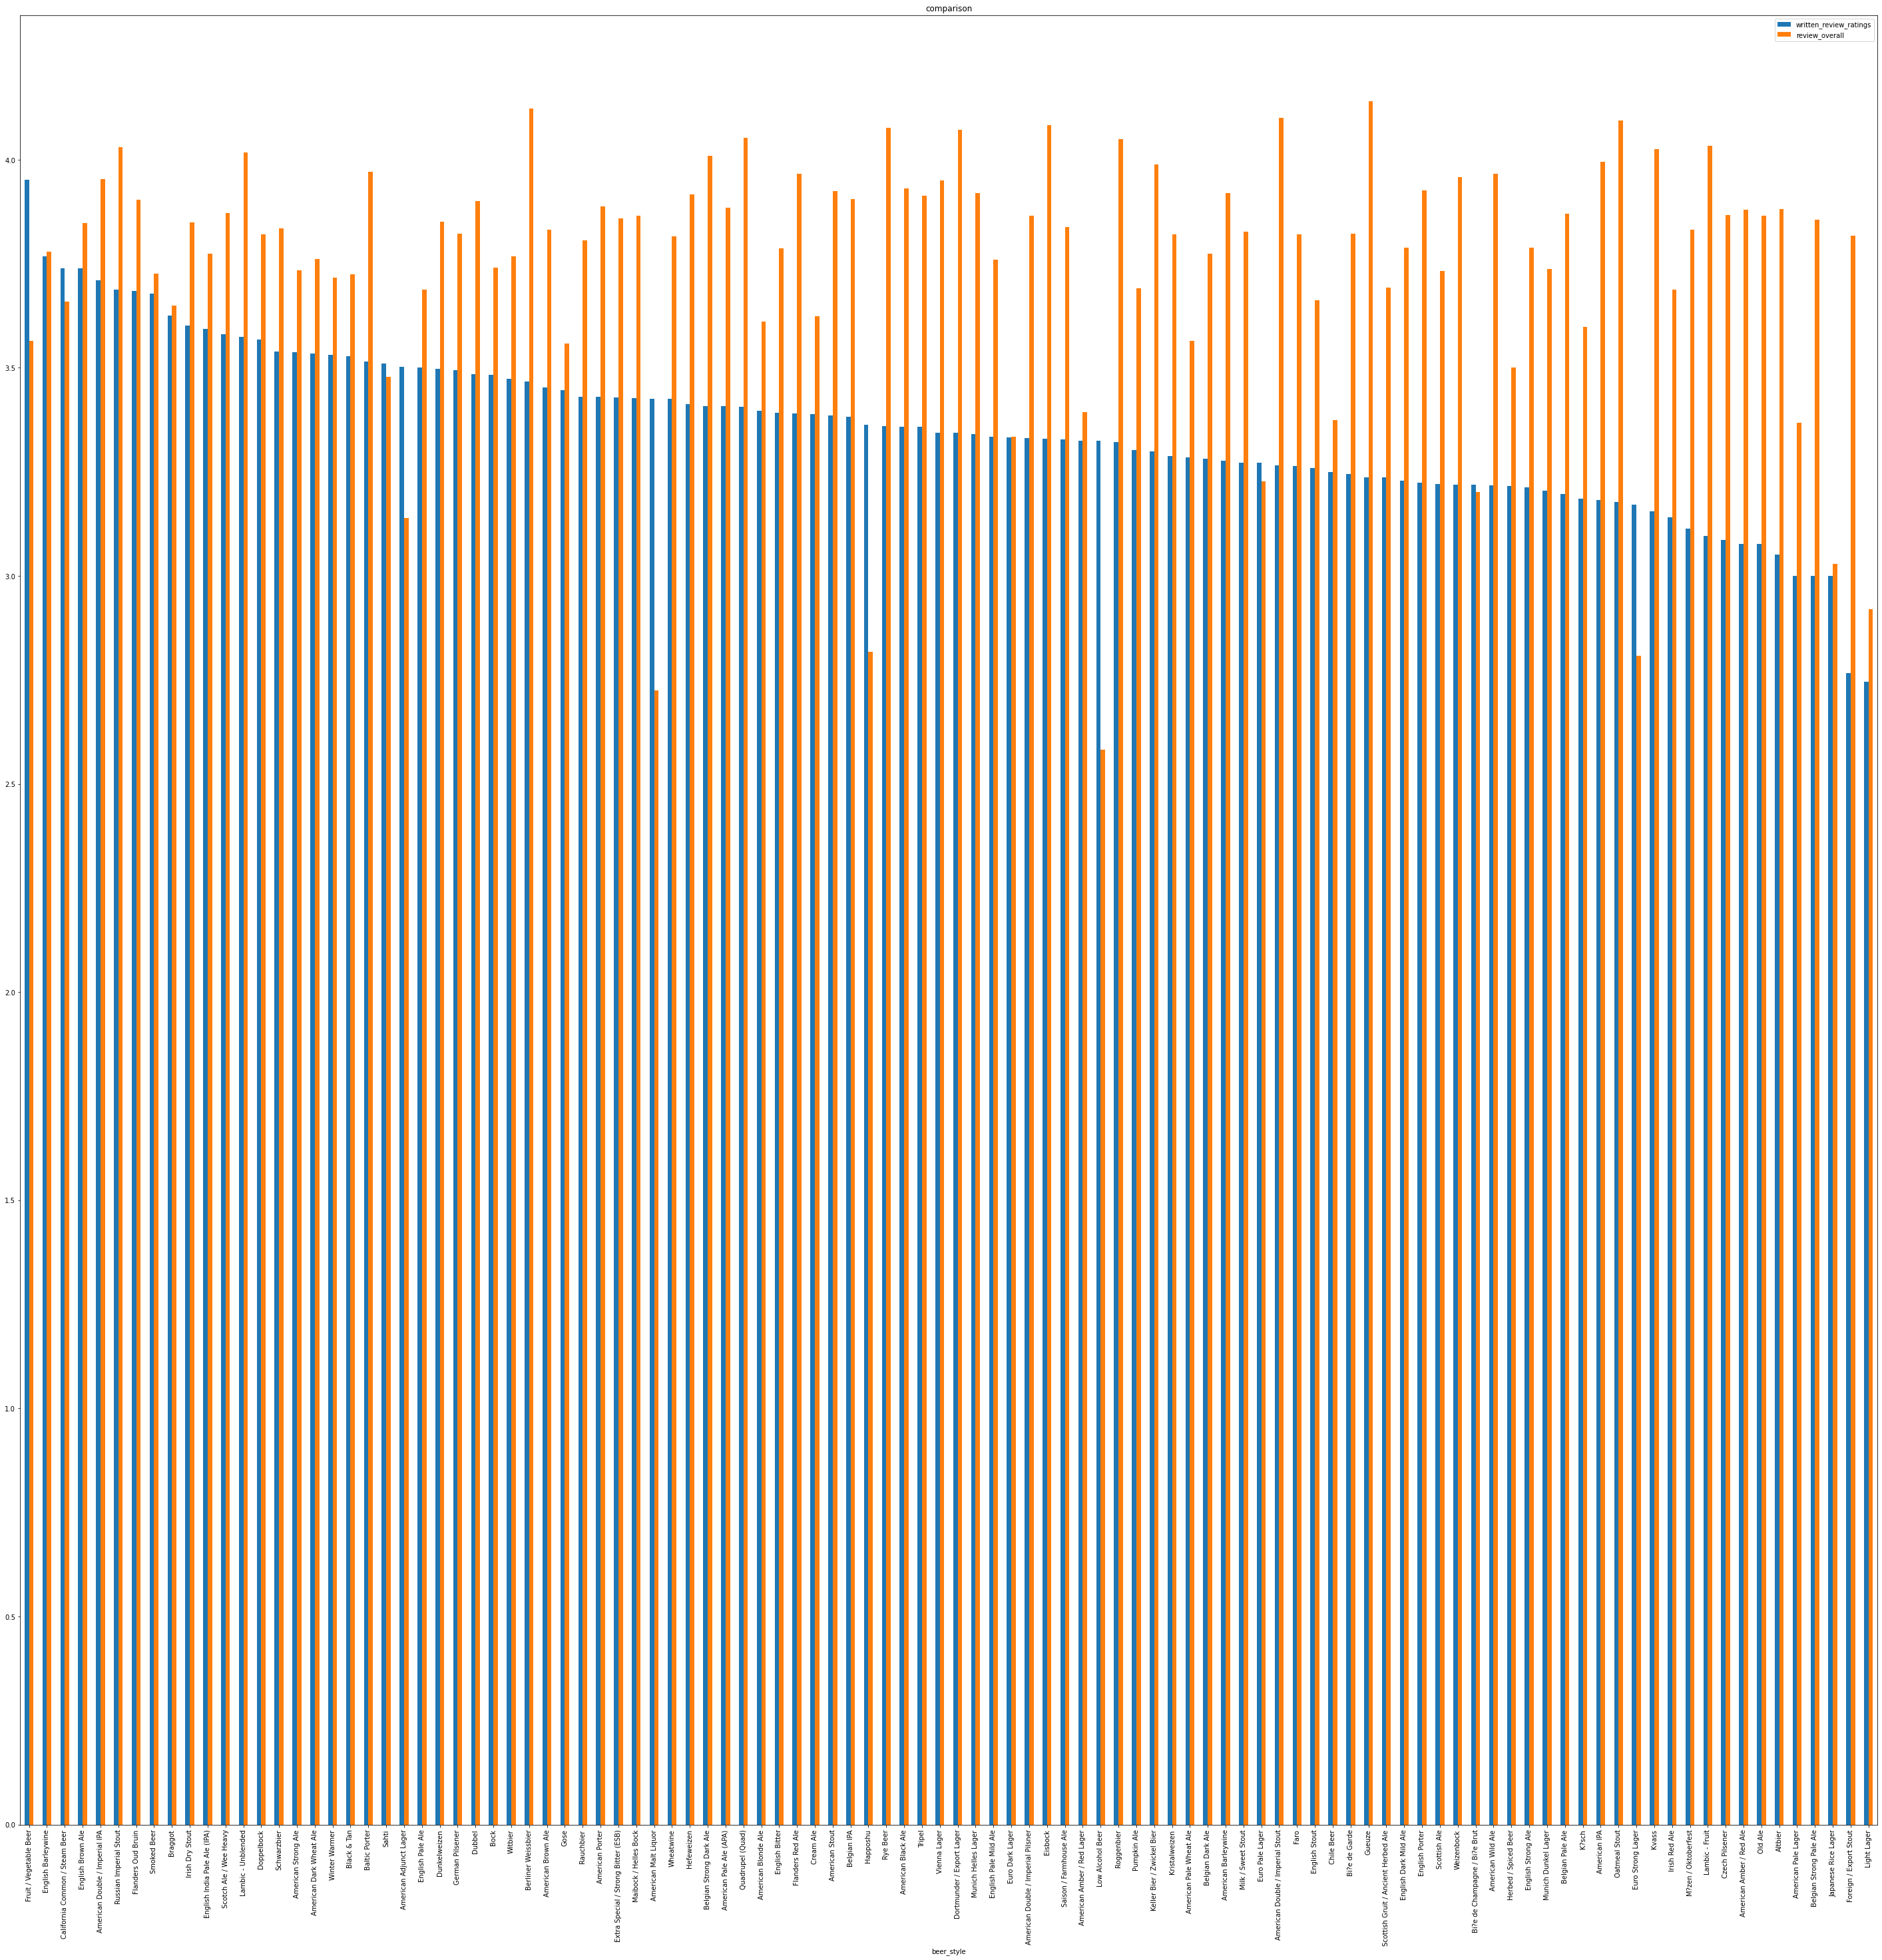

In [143]:
ratings_comparison = best_beers_review_text.merge(beer_style_groupby_overall_ratings).rename(columns = {'cluster_rating':'written_review_ratings'})
ratings_comparison.plot(x = 'beer_style', kind='bar', figsize=(50,50), title='comparison')
plt.savefig("D:\\BeerDataScienceProject\\Ratings_comparison.png")

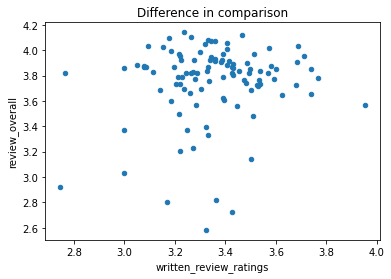

In [165]:
ratings_comparison['Difference'] = ratings_comparison['written_review_ratings'] - ratings_comparison['review_overall']
ratings_comparison.plot(x ='written_review_ratings', y='review_overall', kind='scatter', title='Difference in comparison')
plt.savefig("D:\\BeerDataScienceProject\\Difference_comparison.png")

#### The Difference between the text reviews and the overall reviews are vary much. Beers which got lower ratings were given a bad review but the discrepancy occurs when the review written by the user is mediocre but the ratings is higher. This could be due to the fact that user tend to give higher ratings overall but tend to be very critical while writing a review